# Projeto Eletromagnetismo

Grupo:
- Caio Rocha Calado
- Mateus Araújo Neves

## 1. Discretização do Domínio

Foi utilizada uma discretização triangular, numerando os nós de baixo pra cima e da esquerda para direita. A ordem dos elementos foi definida seguindo o padrão da imagem:

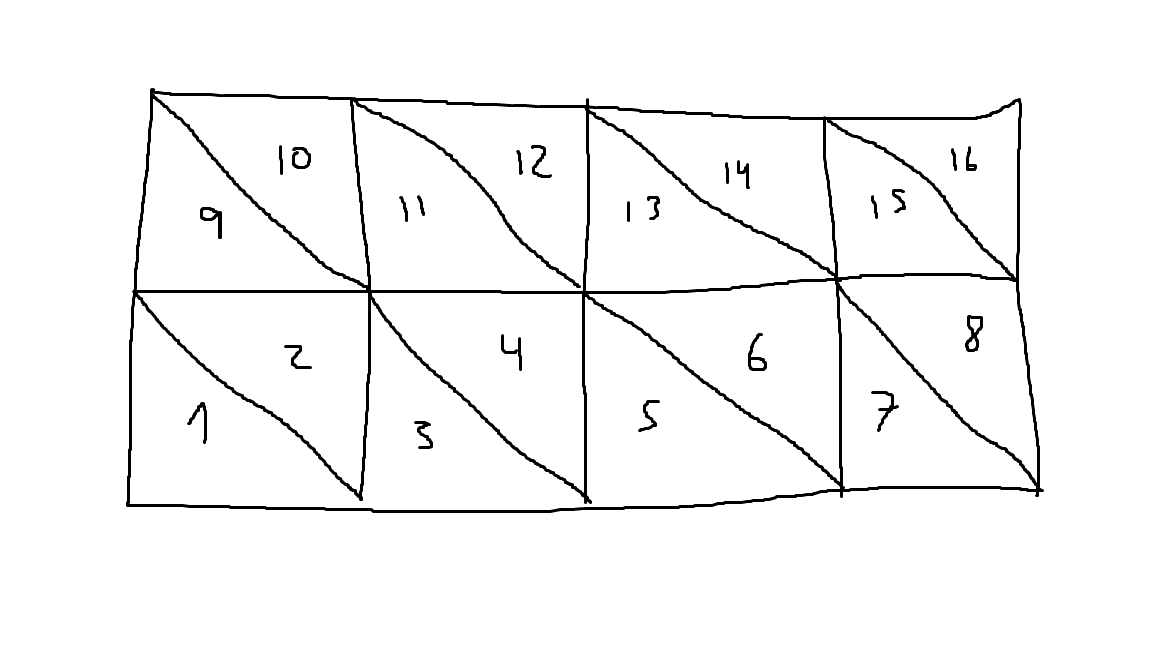

## 2. Função de interpolação

Conforme mostrado em aula, será usada uma função de um plano para cada elemento que aproxime o valor do potencial no elemento, a função é dada por:
$$V(x,y) = V_1 * N_1(x,y) + V_2 * N_2(x,y) +V_3 * N_3(x,y)$$
Onde cada $N_i$ é dado por:
$$N_1(x,y) = \frac{1}{2A} [(y_2 - y_3)x + (-x_2 + x_3)y + x_2 y_3 - x_3 y_2]$$
$$N_2(x,y) = \frac{1}{2A} [(y_3 - y_1)x + (-x_3 + x_1)y + x_3 y_1 - x_1 y_3]$$
$$N_3(x,y) = \frac{1}{2A} [(y_1 - y_2)x + (-x_1 + x_2)y + x_1 y_2 - x_2 y_1]$$
sendo:
$$2A = (x_2 - x_1) (y_3 - y_1) - (x_3 - x_1) (y_2 - y_1)$$

Cada parcela de $V(x,y)$ representa a contribuição do nó para o potencial nos valores intermediários.

## 3. Sistema linear para um elemento

Como desenvolvido em aula, o sistema de um elemento é dado por:

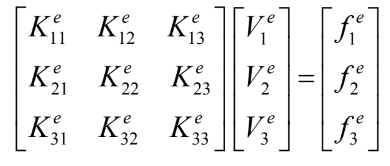

Onde cada $K$ é dado por:

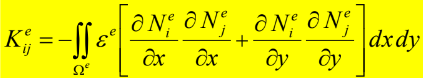

E cada $f$ é dado por:

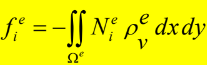

## 4. Sistema linear global

Para montar o sistema linear global, é acrescentado ao sistema de cada elemento linhas para as incógnitas que não aparecem naquele elemento, tornando o sistema com a mesma dimensão do sistema global. Um exemplo pode ser visto no slide:

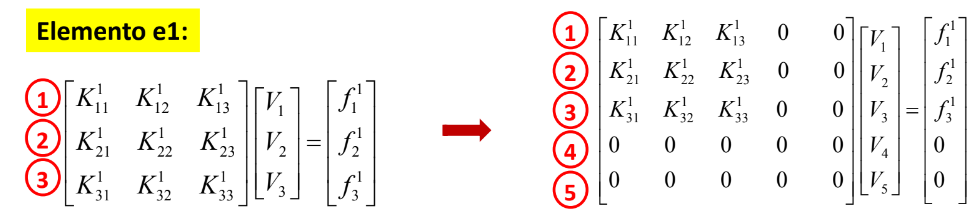

Dessa forma todos os sistemas podem ser somados, gerando o sistema linear global para ser resolvido. O exemplo do slide pode ser visto abaixo:

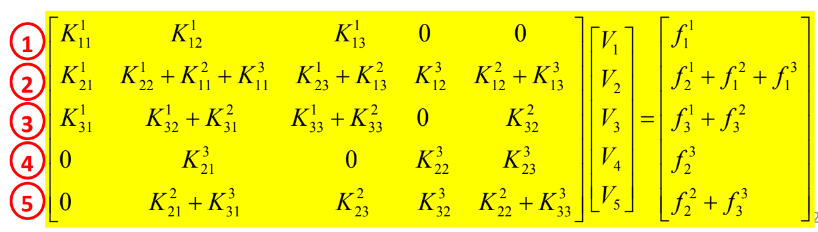

## 5. Condições de Contorno

É aplicada as condições de contorno para eliminar do sistema os $V_i$ que já são conhecidos. Nesse problema temos duas condições de contorno:
1. Os potenciais são zero nas bordas em $x=0$, $x=a$, $y=0$, $y=b$
2. Os potenciais são $V_0$ em cima da fita metálica em $x=[\frac{a-w}{2}, \frac{a+w}{2}]$ e $y=\frac{b}{2}$
  
A partir disso, é eliminada a i-ésima linha da matriz de impedância e a i-ésima coluna multiplicada pelo $V_i$ é levada para o lado independente.
Na implementação, as linhas e colunas não foram de fato removidas do sistema, elas foram apenas modificadas para representar a remoção delas. Por exemplo, se o valor do potencial do i-ésimo nó é conhecido, então linha i é zerada com excessão do elemento na coluna i que terá o valor 1, e para simplificar as outras linhas, os valores de $K_{ji}*V_i$ são passados para o lado direito da equação.

## 6. Implementação

##### Importações

In [2]:
import numpy as np
import matplotlib.pyplot as plt

##### Discretizando a região em triângulos:

In [3]:
def discretize(a, b, nx, ny):
  dimensions = 2

  node_qty = (nx+1)*(ny+1)
  element_qty = nx*ny*2
  node_per_element = 3

  # NODES
  NL = np.zeros([node_qty, dimensions]) # Nodes List

  inc_x = a/nx
  inc_y = b/ny

  n = 0

  for j in range(1, ny+2):
    for i in range(1, nx+2):
      NL[n, 0] = (i-1)*inc_x
      NL[n, 1] = (j-1)*inc_y

      n += 1

  # ELEMENTS
  EL = np.zeros([element_qty, node_per_element]) # Elements List

  n = 0
  
  for j in range(1, ny+1):
    m = 1
    for i in range(1, nx*2+1):
      # Odd Elements
      if ((n+1) % 2 == 1):
        EL[n, 0] = m + ((nx+1)*(j-1))
        EL[n, 1] = EL[n, 0] + 1
        EL[n, 2] = EL[n, 0] + nx + 1
        m += 1
      # Even Elements
      else:
        EL[n, 0] = EL[n-1, 1]
        EL[n, 1] = EL[n-1, 2] + 1
        EL[n, 2] = EL[n-1, 2]
        
      n += 1
  
  return EL.astype(int), NL

##### Printando a região discretizada:

In [4]:
def print_discretized_region(EL, NL, a, b, w):
  NoN = np.size(NL, 0)
  NoE = np.size(EL, 0)

  plt.figure(1)

  count = 1
  for i in range(0, NoN):
    plt.annotate(count, xy=(NL[i,0], NL[i,1]))
    count += 1

  count2 = 1
  for j in range(0, NoE):
    plt.annotate(count2, xy = ((NL[EL[j,0]-1,0]+NL[EL[j,1]-1,0]+NL[EL[j,2]-1,0])/3, 
                               (NL[EL[j,0]-1,1]+NL[EL[j,1]-1,1]+NL[EL[j,2]-1,1])/3), 
                c = 'blue')
    count2 += 1

  x0,y0 = NL[EL[:,0]-1,0], NL[EL[:,0]-1,1]
  x1,y1 = NL[EL[:,1]-1,0], NL[EL[:,1]-1,1]
  x2,y2 = NL[EL[:,2]-1,0], NL[EL[:,2]-1,1]
  plt.plot(np.array([x0,x1]),np.array([y0,y1]),'orange', linewidth=3)
  plt.plot(np.array([x1,x2]),np.array([y1,y2]),'orange', linewidth=3)
  plt.plot(np.array([x2,x0]),np.array([y2,y0]),'orange', linewidth=3)
  plt.hlines(y=b/2, xmin=a/2-w/2, xmax=a/2+w/2, color='r', linewidth=3)
  plt.hlines(y=0, xmin=0, xmax=a, color='r', linewidth=3)
  plt.hlines(y=b, xmin=0, xmax=a, color='r', linewidth=3)
  plt.vlines(ymin=0, ymax=b, x=0, color='r', linewidth=3)
  plt.vlines(ymin=0, ymax=b, x=a, color='r', linewidth=3)

  plt.show()

#### Inicializando Constantes e Discretizando Região:

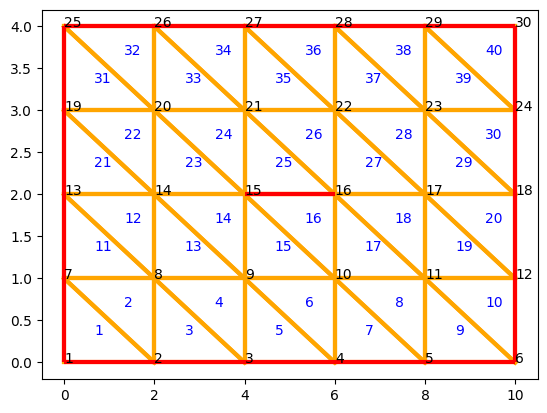

In [5]:
a = 10 # Length of the conductive plates in the x direction (mm)
b = 4  # Length of the conductive plates in the y direction (mm)
w = 2  # Width of the stripline (mm)
V0 = 1 # Potential at the stripline (V)
Er = 1 # Permissivity of the dielectric
nx = 5 # Number of divisions in the x direction
ny = 4 # Number of divisions in the y direction

EL, NL = discretize(a, b, nx, ny) # ElementList, NodeList

print_discretized_region(EL, NL, a, b, w)

#### Criando o Sistema Linear Global:

In [6]:
def linear_system(NL, EL, epsilon):
  NoN = np.size(NL, 0)
  NoE = np.size(EL, 0)
  K = np.zeros((NoN, NoN)) # Stiffness Matrix
  F = np.zeros(NoN)        # Force Vector
  
  #fill stifness matrix
  for i in range(NoE):
    x = NL[EL[i]-1, 0]
    y = NL[EL[i]-1, 1]

    area = 0.5 * np.abs(np.linalg.det(np.array([[x[0], y[0], 1], 
                                                [x[1], y[1], 1], 
                                                [x[2], y[2], 1]])))
    
    N = np.array([[y[1]-y[2], x[2]-x[1]], 
                  [y[2]-y[0], x[0]-x[2]], 
                  [y[0]-y[1], x[1]-x[0]]]) / (2 * area)
    
    for m in range(3):
      for n in range(3):
        K[EL[i,m]-1, EL[i,n]-1] += epsilon * area * (N[m, 0] * N[n, 0] + N[m, 1] * N[n, 1])

  return K, F

#### Filtrando as Condições de Contorno:

In [7]:
def boundary_conditions(NL, K, F, V0, w):
  NoN = np.size(NL, 0)
  
  for i in range(NoN):
    x, y = NL[i]

    if y == 0 or y == b or x == 0 or x == a:
      for j in range(NoN):
        K[j,i] = 0
      
      for j in range(NoN):
        K[i,j] = 1 if (i == j) else 0

      F[i] = 0

    if y == b/2 and x >= (a-w)/2 and x <= (a+w)/2:
      for j in range(NoN):
        F[j] -= V0*K[j,i]
        K[j,i] = 0
      
      for j in range(NoN):
        K[i,j] = 1 if (i == j) else 0

      F[i] = V0

  return K, F

#### Rodando as Funções:

In [8]:
a = 10 # Length of the conductive plates in the x direction (mm)
b = 4  # Length of the conductive plates in the y direction (mm)
w = 2  # Width of the stripline (mm)
V0 = 1 # Potential at the stripline (V)
epsilon = 1 # Permissivity of the dielectric
nx = 5 # Number of divisions in the x direction
ny = 4 # Number of divisions in the y direction

EL, NL = discretize(a, b, nx, ny) # ElementList, NodeList

K, F = linear_system(NL, EL, epsilon)

K, F = boundary_conditions(NL, K, F, V0, w)

solution = np.linalg.solve(K, F)

print(solution)

[0.         0.         0.         0.         0.         0.
 0.         0.12624585 0.45847176 0.45847176 0.12624585 0.
 0.         0.20099668 1.         1.         0.20099668 0.
 0.         0.12624585 0.45847176 0.45847176 0.12624585 0.
 0.         0.         0.         0.         0.         0.        ]


#### Printando Potenciais Calculados:

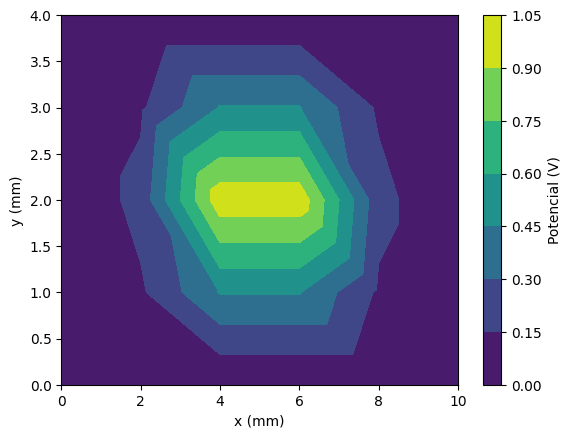

In [9]:
plt.figure()
plt.tricontourf(NL[:, 0], NL[:, 1], EL-1, solution, cmap='viridis')
plt.colorbar(label='Potencial (V)')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.show()

#### Para N = 100:

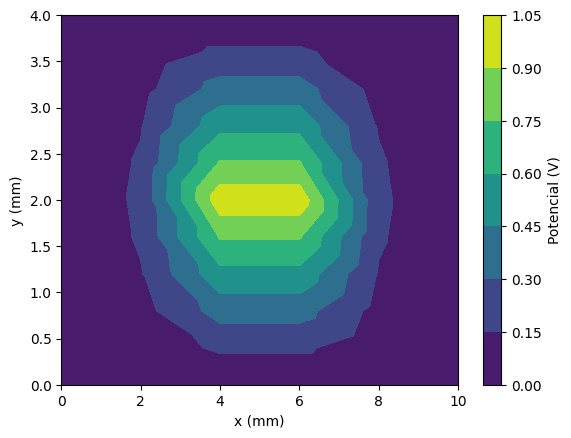

In [15]:
nx = 5 # Number of divisions in the x direction
ny = 10 # Number of divisions in the y direction

EL, NL = discretize(a, b, nx, ny) # ElementList, NodeList

K, F = linear_system(NL, EL, epsilon)

K, F = boundary_conditions(NL, K, F, V0, w)

solution = np.linalg.solve(K, F)

#print(solution)

plt.figure()
plt.tricontourf(NL[:, 0], NL[:, 1], EL-1, solution, cmap='viridis')
plt.colorbar(label='Potencial (V)')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.show()

#### Para N = 200:

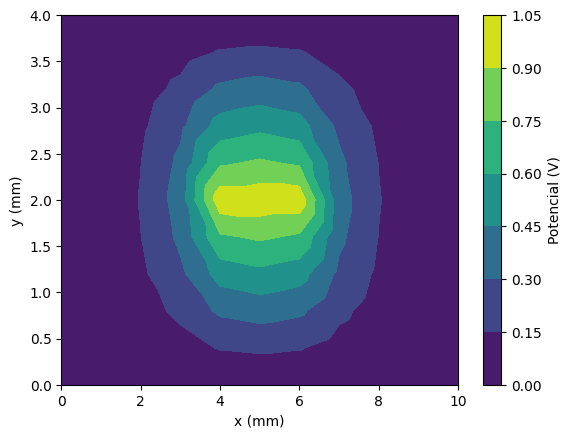

In [16]:
nx = 10 # Number of divisions in the x direction
ny = 10 # Number of divisions in the y direction

EL, NL = discretize(a, b, nx, ny) # ElementList, NodeList

K, F = linear_system(NL, EL, epsilon)

K, F = boundary_conditions(NL, K, F, V0, w)

solution = np.linalg.solve(K, F)

#print(solution)

plt.figure()
plt.tricontourf(NL[:, 0], NL[:, 1], EL-1, solution, cmap='viridis')
plt.colorbar(label='Potencial (V)')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.show()

#### Para N = 5000:

[0. 0. 0. ... 0. 0. 0.]


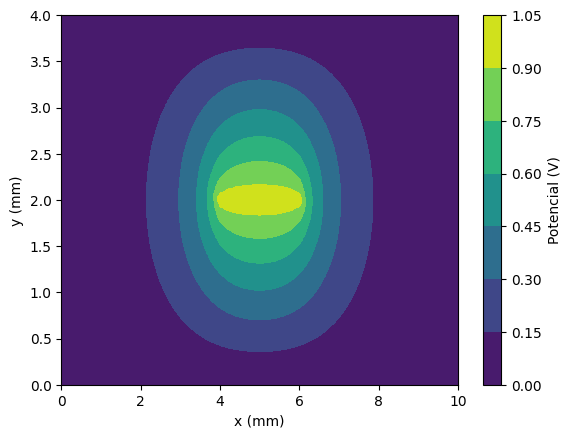

In [17]:
nx = 50 # Number of divisions in the x direction
ny = 50 # Number of divisions in the y direction

EL, NL = discretize(a, b, nx, ny) # ElementList, NodeList

K, F = linear_system(NL, EL, epsilon)

K, F = boundary_conditions(NL, K, F, V0, w)

solution = np.linalg.solve(K, F)

print(solution)

plt.figure()
plt.tricontourf(NL[:, 0], NL[:, 1], EL-1, solution, cmap='viridis')
plt.colorbar(label='Potencial (V)')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.show()

#### Discussão

É possível notar que o aumento do número de triângulos aproxima cada vez mais a solução encontrada do valor do potencial no dielétrico, e quando o número de triângulos tende ao infinito, a solução encontrada tende a solução no domínio discreto.